# Smart Sales Analysis

-------
### Organize imports and define paths

In [80]:
# Core imports
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, year, month, quarter, sum as _sum

# Define paths using pathlib
PROJECT_ROOT = Path("/Users/joannafarris/Projects/smart-store-joannafarris")
JDBC_JAR_PATH = PROJECT_ROOT / "lib" / "sqlite-jdbc-3.49.1.0.jar"
DB_PATH = PROJECT_ROOT / "data" / "dw" / "smart_sales.db"

# Define the JDBC URL
DB_URL = f"jdbc:sqlite:{str(DB_PATH)}"

--------
### Configure Spark for SQLite connection

In [81]:
# Stop existing Spark session if one is already active
if 'spark' in locals() and spark is not None:
    spark.stop()

# Create SparkSession with the JDBC jar
spark = SparkSession.builder \
    .appName("SmartSales") \
    .config("spark.jars", str(JDBC_JAR_PATH)) \
    .config("spark.driver.extraClassPath", str(JDBC_JAR_PATH)) \
    .getOrCreate()

# Set Spark's log level to ERROR to reduce output
spark.sparkContext.setLogLevel("ERROR")

________
### Load tables into Spark using the SQLite JDBC driver

In [82]:
try:
    df_customer = spark.read.format("jdbc") \
        .option("url", DB_URL) \
        .option("dbtable", "customer") \
        .option("driver", "org.sqlite.JDBC") \
        .load()
    df_customer.show()
except Exception as e:
    print(f"Error loading data: {e}")

+-----------+----------------+------+----------+--------------+------------------------+
|customer_id|            name|region| join_date|loyalty_points|preferred_contact_method|
+-----------+----------------+------+----------+--------------+------------------------+
|       1001|   William White|  East|2021-11-11|           150|                    Text|
|       1002|    Wylie Coyote|  East|2023-02-14|           240|                    Text|
|       1003|       Dan Brown|  West|2023-10-19|           330|                    Text|
|       1004|       Chewbacca|  West|2022-11-09|           285|                    Text|
|       1005|          Dr Who| North|2023-08-18|           315|                    Call|
|       1006|   Tiffany James| South|2021-06-07|            60|                    Text|
|       1007|   Susan Johnson| South|2023-06-30|            30|                   Email|
|       1008|      Tony Stark| North|2020-05-01|           345|                    Text|
|       1009|    Jaso

In [83]:
try:
    df_product = spark.read.format("jdbc") \
        .option("url", DB_URL) \
        .option("dbtable", "product") \
        .option("driver", "org.sqlite.JDBC") \
        .load()
    df_product.show()
except Exception as e:
    print(f"Error loading data: {e}")

+----------+------------+-----------+--------------+--------------+--------+
|product_id|product_name|   category|unit_price_usd|stock_quantity|supplier|
+----------+------------+-----------+--------------+--------------+--------+
|       101|      laptop|Electronics|        793.12|            31|   Apple|
|       102|      hoodie|   Clothing|          39.1|           205|     HIT|
|       103|       cable|Electronics|         22.76|           150|      SM|
|       104|         hat|   Clothing|          43.1|            51|     HIT|
|       105|    football|     Sports|         19.78|           102|    Nike|
|       106|  controller|Electronics|         88.98|            42|      SM|
|       107|      jacket|   Clothing|         67.02|            37|     HIT|
|       108|   protector|Electronics|         12.56|           303|      SM|
+----------+------------+-----------+--------------+--------------+--------+



In [84]:
try:
    df_sales = spark.read.format("jdbc") \
        .option("url", DB_URL) \
        .option("dbtable", "sales") \
        .option("driver", "org.sqlite.JDBC") \
        .load()
    df_sales.show()
except Exception as e:
    print(f"Error loading data: {e}")

+-------+----------+-----------+----------+--------+-----------+---------------+------------+------------+
|sale_id| sale_date|customer_id|product_id|store_id|campaign_id|sale_amount_usd|bonus_points|payment_type|
+-------+----------+-----------+----------+--------+-----------+---------------+------------+------------+
|    550|2024-01-06|       1008|       102|     404|          0|             39|           5|       debit|
|    551|2024-01-06|       1009|       105|     403|          0|             19|          40|      credit|
|    552|2024-01-16|       1004|       107|     404|          0|            335|          50|        cash|
|    553|2024-01-16|       1006|       102|     406|          0|            195|          55|      credit|
|    554|2024-01-25|       1005|       102|     405|          0|            117|          60|       debit|
|    555|2024-01-25|       1001|       101|     401|          0|           2379|          35|      credit|
|    556|2024-01-29|       1009|     

_____________
### Use Spark SQL to perform a grouped query

In [85]:
# Register DataFrames as temporary views (if not already done)
df_sales.createOrReplaceTempView("sales")
df_customer.createOrReplaceTempView("customer")

# Write query using Spark SQL
df_top_customers = spark.sql("""
SELECT c.name, SUM(s.sale_amount_usd) AS total_spent
FROM sales s
JOIN customer c ON s.customer_id = c.customer_id
GROUP BY c.name
ORDER BY total_spent DESC
""")

# Show Spark results
df_top_customers.show()

# Convert to Pandas for later visualization
df_top_customers_pd = df_top_customers.toPandas()

+----------------+-----------+
|            name|total_spent|
+----------------+-----------+
|   William White|      23747|
|Hermione Granger|      22817|
|   Susan Johnson|      12418|
|       Chewbacca|      11811|
|   Tiffany James|      11711|
| Hermione Grager|       8748|
|    Wylie Coyote|       7430|
|          Dr Who|       4061|
|       Dan Brown|       2424|
|    Jason Bourne|       1804|
|      Tony Stark|       1544|
+----------------+-----------+



__________
### Slicing: Filter sales by date range

In [86]:
df_filtered = df_sales.filter(df_sales.sale_date >= "2023-01-01").show()

+-------+----------+-----------+----------+--------+-----------+---------------+------------+------------+
|sale_id| sale_date|customer_id|product_id|store_id|campaign_id|sale_amount_usd|bonus_points|payment_type|
+-------+----------+-----------+----------+--------+-----------+---------------+------------+------------+
|    550|2024-01-06|       1008|       102|     404|          0|             39|           5|       debit|
|    551|2024-01-06|       1009|       105|     403|          0|             19|          40|      credit|
|    552|2024-01-16|       1004|       107|     404|          0|            335|          50|        cash|
|    553|2024-01-16|       1006|       102|     406|          0|            195|          55|      credit|
|    554|2024-01-25|       1005|       102|     405|          0|            117|          60|       debit|
|    555|2024-01-25|       1001|       101|     401|          0|           2379|          35|      credit|
|    556|2024-01-29|       1009|     

______________
### Dicing: Group sales by product and region

Although customer region was available in the customer table, I chose here to create a region column in the sales data using store_id, since sales performance is typically analyzed by store location rather than customer residence. This also helped account for customers whose purchases occurred outside their listed home region.

In [108]:
# Define the mapping using when/otherwise
df_sales = df_sales.withColumn("region", 
                   when(df_sales["store_id"] == 401, "East")
                   .when(df_sales["store_id"] == 402, "East")
                   .when(df_sales["store_id"] == 403, "West")
                   .when(df_sales["store_id"] == 404, "West")
                   .when(df_sales["store_id"] == 405, "North")
                   .when(df_sales["store_id"] == 406, "South")
                   .otherwise("Unknown"))

# Join sales with product to get the category column
df_joined = df_sales.join(df_product, on="product_id")

# Group by category and region, then aggregate
df_joined.groupBy("category", "region") \
         .agg(_sum("sale_amount_usd").alias("total_sales")) \
         .orderBy("category", "region") \
         .show()


+-----------+------+-----------+
|   category|region|total_sales|
+-----------+------+-----------+
|   Clothing|  East|       4078|
|   Clothing| North|       5044|
|   Clothing| South|       1256|
|   Clothing|  West|       3032|
|Electronics|  East|      58389|
|Electronics| North|      11178|
|Electronics| South|      10416|
|Electronics|  West|      14453|
|     Sports|  East|        275|
|     Sports| North|        257|
|     Sports| South|         39|
|     Sports|  West|         98|
+-----------+------+-----------+



For comparison, I also created an alternative version by joining the product and customer tables. This version groups sales by product category and the region where the customer lives. The results differ—sometimes significantly—from the store-based chart, highlighting how the choice of grouping dimension can impact the interpretation of sales performance.

In [107]:
# Give aliases to each DataFrame before joining
sales = df_sales.alias("s")
product = df_product.alias("p")
customer = df_customer.alias("c")

# Join the tables
df_combined = sales \
    .join(product, on="product_id") \
    .join(customer, on="customer_id")

# Use c.region to refer to the customer's region
df_diced = df_combined.groupBy("category", customer["region"]) \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("category", "region")

df_diced.show()

+-----------+------+-----------+
|   category|region|total_sales|
+-----------+------+-----------+
|   Clothing|  East|       4078|
|   Clothing| North|       3581|
|   Clothing| South|       3384|
|   Clothing|  West|       2367|
|Electronics|  East|      58389|
|Electronics| North|       1688|
|Electronics| South|      20706|
|Electronics|  West|      13653|
|     Sports|  East|        275|
|     Sports| North|        336|
|     Sports| South|         39|
|     Sports|  West|         19|
+-----------+------+-----------+



_______________
### Drilldown: Aggregate sales by year → quarter → month

In [88]:
df_sales = df_sales.withColumn("year", year("sale_date")) \
                   .withColumn("quarter", quarter("sale_date")) \
                   .withColumn("month", month("sale_date"))
                   
df_sales.groupby("year") \
        .agg(_sum("sale_amount_usd").alias("total_sales")) \
        .show()
df_sales.groupBy("quarter") \
        .agg(_sum("sale_amount_usd").alias("total_sales")) \
        .orderBy("quarter") \
        .show()
df_sales.groupBy("month") \
        .agg(_sum("sale_amount_usd").alias("total_sales")) \
        .orderBy("month") \
        .show()

+----+-----------+
|year|total_sales|
+----+-----------+
|2024|     108515|
+----+-----------+

+-------+-----------+
|quarter|total_sales|
+-------+-----------+
|      1|      33161|
|      2|      34359|
|      3|      35143|
|      4|       5852|
+-------+-----------+

+-----+-----------+
|month|total_sales|
+-----+-----------+
|    1|       6428|
|    2|      14584|
|    3|      12149|
|    4|      16939|
|    5|      10980|
|    6|       6440|
|    7|      21032|
|    8|       4621|
|    9|       9490|
|   10|       5852|
+-----+-----------+



____________________
### Create a bar chart for Top Customers

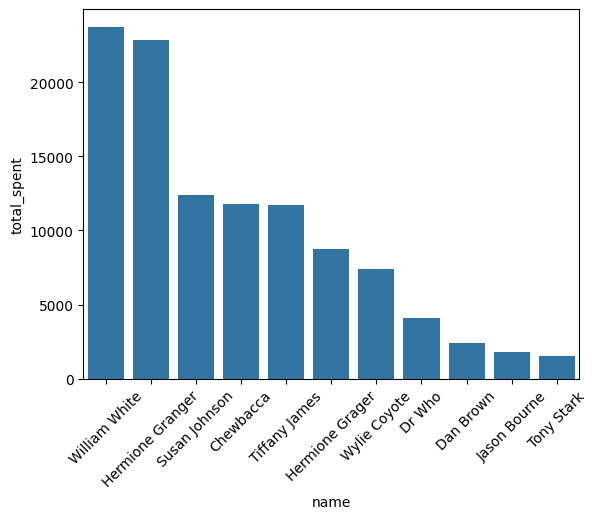

In [89]:
# Use Top Customers DataFrame previously converted into pandas 
sns.barplot(data=df_top_customers_pd, x="name", y="total_spent")
plt.xticks(rotation=45)
plt.show()

_____________
### Create a line chart for Sales Trends

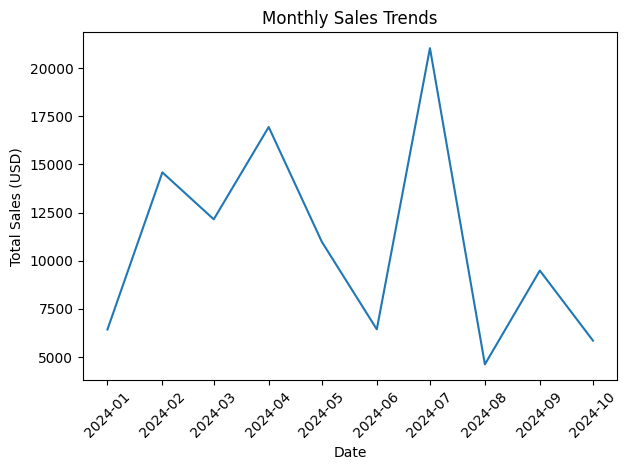

In [90]:
df_sales_trends = df_sales \
    .withColumn("year", year("sale_date")) \
    .withColumn("month", month("sale_date")) \
    .groupBy("year", "month") \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("year", "month")

# Convert to Pandas
df_sales_trends_pd = df_sales_trends.toPandas()

# Optional: create a combined date column
df_sales_trends_pd["date"] = pd.to_datetime(df_sales_trends_pd[["year", "month"]].assign(day=1))

# Plot
sns.lineplot(data=df_sales_trends_pd, x="date", y="total_sales")
plt.xticks(rotation=45)
plt.title("Monthly Sales Trends")
plt.xlabel("Date")
plt.ylabel("Total Sales (USD)")
plt.tight_layout()
plt.show()


In [105]:
from pyspark.sql.functions import sum as _sum

# Give aliases to each DataFrame before joining
sales = df_sales.alias("s")
product = df_product.alias("p")
customer = df_customer.alias("c")

# Join the tables
df_combined = sales \
    .join(product, on="product_id") \
    .join(customer, on="customer_id")

# Use c.region to refer to the customer's region
df_diced = df_combined.groupBy("category", customer["region"]) \
    .agg(_sum("sale_amount_usd").alias("total_sales")) \
    .orderBy("category", "region")

df_diced.show()



+-----------+------+-----------+
|   category|region|total_sales|
+-----------+------+-----------+
|   Clothing|  East|       4078|
|   Clothing| North|       3581|
|   Clothing| South|       3384|
|   Clothing|  West|       2367|
|Electronics|  East|      58389|
|Electronics| North|       1688|
|Electronics| South|      20706|
|Electronics|  West|      13653|
|     Sports|  East|        275|
|     Sports| North|        336|
|     Sports| South|         39|
|     Sports|  West|         19|
+-----------+------+-----------+

